Some guidance as to how to create the dataset for your model if you are not sure how to get started. One way to calculate cost, for a volume of the security in a period of time, is to see what bid levels you would have to fill to sell that volume. The cost is then the difference between the bid prices you sell at in the different levels, and the mid-price (middle of L1 Bid and L1 Ask). For example, if I am selling 2,000 units and Level 1 has a bid size of 1,000, and Level 2 has a bid size of 2,000, I would sell 1,000 units at the Level 1 bid price and 1,000 as the Level 2 bid price.

 

If you have any other ideas we’d be interested in what you can come up with. You might also have more success if your time periods are longer (e.g. in hours and days not minutes) – but please feel free to experiment yourselves. Once you have your dataset with your predicted variable calculated, you can train and test your model, and calculate the accuracy of your model. Just try your best – this task is not easy. Do your best to create a model, and if you’re unable to build something successful, please submit your code regardless and try to answer the follow on questions.

 
Impact cost:

* [Impact Cost calculation](https://economictimes.indiatimes.com/definition/impact-cost#:~:text=Definition%3A%20Impact%20cost%20is%20the,liquidity%20condition%20on%20the%20counter.&text=This%20is%20a%20cost%20that,to%20lack%20of%20market%20liquidity).
* [Limit Order Books](https://www.imperial.ac.uk/media/imperial-college/research-centres-and-groups/cfm-imperial-institute-of-quantitative-finance/events/imperial-eth-2016/Julius-Bonart.pdf)

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import etl 
import liquidity_costs as lc
import ml_modelling as ml
import config as cfg


# Get data
ticker_df, lob_df = etl.get_data()
asks_costs_df, bids_costs_df = etl.get_costs_data()
asks_costs_df.dropna(axis=0, inplace=True)
bids_costs_df.dropna(axis=0, inplace=True)

def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

In [2]:
ticker_df.rename({"Time_Hour":"Time"},axis=1, inplace=True)
for df in [asks_costs_df,bids_costs_df]:
    df.rename({"Time_Minute":"Time"},axis=1, inplace=True)
    
for df in [ticker_df, asks_costs_df, bids_costs_df]:
    df["Time"] = pd.to_datetime(df["Time"],  utc = True)
    
merged_df = ticker_df.merge(asks_costs_df, on="Time")

In [3]:
ticker_df

,Time,Instrument_Code,Open,High,Low,Close,VWAP,TWAP,NumberOfTrades,Volume,Turnover,MinTimeHour,MaxTimeHour,Avg_Bid_Ask_Spread
0,2018-01-04 08:00:00+00:00,ABC,53.545455,54.254545,53.518182,54.209091,53.951161,53.989410,3365,2.546155e+05,1.663332e+09,2020-01-02 08:00:02.736099+00:00,2020-01-02 08:59:58.820761+00:00,-0.014760
1,2018-01-04 09:00:00+00:00,ABC,54.209091,54.363636,54.100000,54.290909,54.224500,54.225053,1368,7.781718e+04,5.105765e+08,2020-01-02 09:00:11.940563+00:00,2020-01-02 09:59:58.746897+00:00,0.013481
2,2018-01-04 10:00:00+00:00,ABC,54.281818,54.318182,54.218182,54.245455,54.265969,54.266231,909,5.819173e+04,3.820993e+08,2020-01-02 10:00:03.826511+00:00,2020-01-02 10:59:59.987086+00:00,0.011557
3,2018-01-04 11:00:00+00:00,ABC,54.245455,54.272727,54.118182,54.136364,54.183729,54.182949,501,3.476209e+04,2.279050e+08,2020-01-02 11:00:02.479285+00:00,2020-01-02 11:59:48.672869+00:00,0.011537
4,2018-01-04 12:00:00+00:00,ABC,54.181818,54.204591,54.100000,54.177318,54.158934,54.156843,474,3.464418e+04,2.270226e+08,2020-01-02 12:02:18.720769+00:00,2020-01-02 12:59:28.065067+00:00,-0.014078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,2018-06-14 11:00:00+00:00,ABC,34.986364,35.080445,34.636364,34.718182,34.816504,34.796264,2697,1.527895e+05,6.432968e+08,2020-06-11 11:02:29.938248+00:00,2020-06-11 11:59:40.498842+00:00,0.004185
1019,2018-06-14 12:00:00+00:00,ABC,34.713636,34.770273,34.459091,34.509091,34.581861,34.582963,3527,1.829505e+05,7.655632e+08,2020-06-11 12:00:07.550470+00:00,2020-06-11 12:59:59.608868+00:00,0.007030
1020,2018-06-14 13:00:00+00:00,ABC,34.500000,34.768182,34.390909,34.631818,34.539470,34.540540,5375,2.995654e+05,1.252005e+09,2020-06-11 13:00:00.488951+00:00,2020-06-11 13:59:59.480509+00:00,0.008004
1021,2018-06-14 14:00:00+00:00,ABC,34.631818,34.668182,34.330455,34.368182,34.445519,34.442075,5470,3.029528e+05,1.262553e+09,2020-06-11 14:00:00.070819+00:00,2020-06-11 14:59:59.988703+00:00,0.007508


In [4]:
# Time to sin/cos: https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
# Encoding time: https://stats.stackexchange.com/questions/311494/best-practice-for-encoding-datetime-in-machine-learning
time_cols = ["Time", "MinTimeHour", "MaxTimeHour"]
new_time_cols = []

seconds_in_day = 24*60*60

for col in time_cols:
    merged_df[col] = pd.to_datetime(merged_df["Time"]).astype(int)/ 10**9
    sin_col, cos_col = f'{col}_Sin', f'{col}_Cos'
    merged_df[sin_col] = np.sin(2*np.pi*merged_df[col]/seconds_in_day)
    merged_df[cos_col] = np.cos(2*np.pi*merged_df[col]/seconds_in_day)
    new_time_cols.extend([col, sin_col,cos_col] )

In [5]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

training_df = merged_df._get_numeric_data()

In [6]:
X, y = ml.get_X_y(training_df, "liquidity_cost")
X.drop("intercept", axis=1, inplace=True)

In [7]:
# X_cols = set(new_time_cols)
# X_cols.update(set(["Volume", "NumberOfTrades"]))
# X_cols = list(X_cols)
# X_cols
# X= X[X_cols]

In [8]:
#from sklearn.preprocessing import MinMaxScaler
#import sklearn
#scaler = MinMaxScaler()
#y = scaler.fit_transform(y.values.reshape(-1,1), (-100,100))

In [9]:
cv_helper = ml.EstimatorSelectionHelper(
    ml.MODELS, 
    ml.PARAMS,
)
cv_helper.fit(X, y,cv=5, scoring='neg_mean_squared_error')

Running GridSearchCV for ExtraTreesRegressor.
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    4.5s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   19.9s
[Parallel(n_jobs=3)]: Done 210 out of 210 | elapsed:   25.0s finished


In [10]:
scores = cv_helper.score_summary(sort_by='max_score')
scores_col = [col for col in scores.columns if "score" in col]
for col in scores_col:
    # Turn neg_mean_squared_error to MSE
    scores[col] = scores[col] * -1

ExtraTreesRegressor


In [11]:
scores

,estimator,min_score,mean_score,max_score,std_score,max_depth,n_estimators,random_state
14,ExtraTreesRegressor,1.82334e-10,8.02882e-11,1.74477e-12,-8.0006e-11,3,100,121301
15,ExtraTreesRegressor,1.83019e-10,8.02026e-11,1.75434e-12,-7.96739e-11,3,150,121301
16,ExtraTreesRegressor,1.81959e-10,7.94835e-11,1.7633e-12,-7.92069e-11,3,200,121301
17,ExtraTreesRegressor,1.84016e-10,8.06766e-11,1.76831e-12,-7.94514e-11,3,250,121301
0,ExtraTreesRegressor,1.7235e-10,5.19999e-11,1.77882e-12,-6.25607e-11,1,16,121301
2,ExtraTreesRegressor,1.71925e-10,5.22068e-11,1.78407e-12,-6.22494e-11,1,100,121301
3,ExtraTreesRegressor,1.71777e-10,5.20614e-11,1.78447e-12,-6.22568e-11,1,150,121301
4,ExtraTreesRegressor,1.71738e-10,5.20213e-11,1.78979e-12,-6.22571e-11,1,200,121301
5,ExtraTreesRegressor,1.71661e-10,5.20554e-11,1.79042e-12,-6.21966e-11,1,250,121301
1,ExtraTreesRegressor,1.71761e-10,5.18742e-11,1.79881e-12,-6.23356e-11,1,32,121301


In [12]:
from catboost import CatBoostRegressor
cb_model =  CatBoostRegressor(n_estimators=15, depth=2, random_seed=cfg.RANDOM_STATE).fit(X, y)

from sklearn.ensemble import ExtraTreesRegressor
etr_model =  ExtraTreesRegressor(n_estimators=16, max_depth=2, random_state=cfg.RANDOM_STATE).fit(X, y)

Learning rate set to 0.5
0:	learn: 0.0000053	total: 52.7ms	remaining: 738ms
1:	learn: 0.0000050	total: 54.1ms	remaining: 352ms
2:	learn: 0.0000049	total: 57.6ms	remaining: 230ms
3:	learn: 0.0000044	total: 62ms	remaining: 171ms
4:	learn: 0.0000040	total: 64.4ms	remaining: 129ms
5:	learn: 0.0000040	total: 66ms	remaining: 99ms
6:	learn: 0.0000040	total: 66.8ms	remaining: 76.3ms
7:	learn: 0.0000038	total: 74.5ms	remaining: 65.2ms
8:	learn: 0.0000037	total: 78ms	remaining: 52ms
9:	learn: 0.0000035	total: 79.5ms	remaining: 39.8ms
10:	learn: 0.0000033	total: 81ms	remaining: 29.5ms
11:	learn: 0.0000028	total: 82.6ms	remaining: 20.7ms
12:	learn: 0.0000027	total: 86.6ms	remaining: 13.3ms
13:	learn: 0.0000027	total: 89.1ms	remaining: 6.36ms
14:	learn: 0.0000025	total: 90.2ms	remaining: 0us


In [13]:
etr_model.fit(X, y)

ExtraTreesRegressor(max_depth=2, n_estimators=16, random_state=121301)

In [14]:
etr_model.predict(X.head())

array([-2.75943105e-06, -2.75943105e-06, -2.75943105e-06, -2.75943105e-06,
       -2.75943105e-06])

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline

from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence


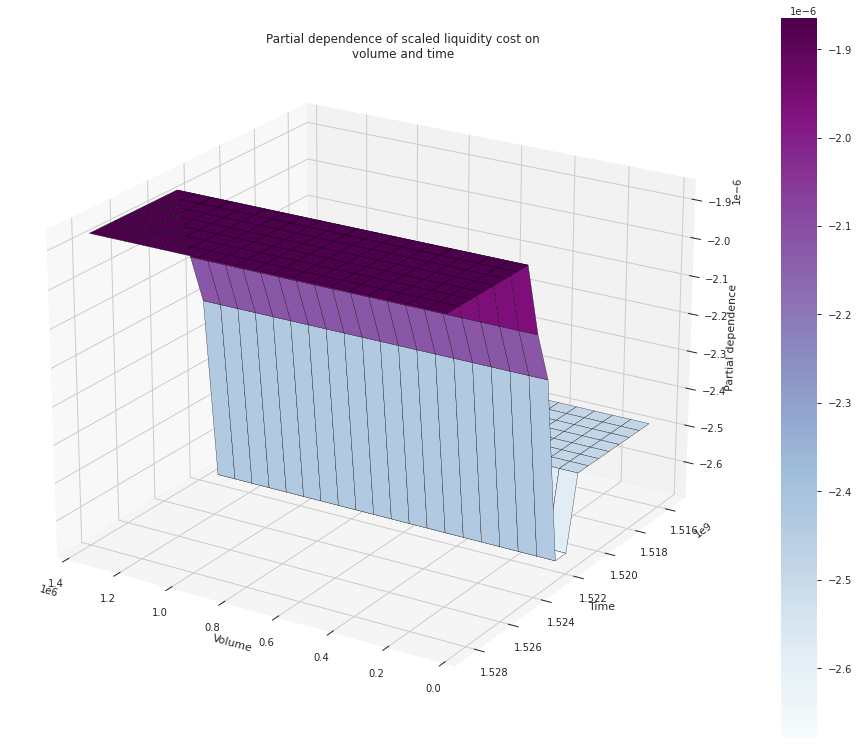

In [16]:
fig = plt.figure(figsize=(15,10))

features = ('Volume', 'Time')
pdp, axes = partial_dependence(etr_model, X, features=features,
                               grid_resolution=20)
XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle('Partial dependence of scaled liquidity cost on\n'
             'volume and time')
plt.subplots_adjust(top=0.9)

plt.show()

In [17]:
import shap

# load JS visualization code to notebook
shap.initjs()
explainer = shap.TreeExplainer(etr_model)
shap_values = explainer.shap_values(X)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


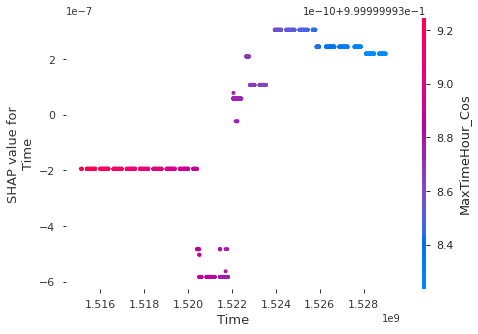

In [18]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Time", shap_values, X)

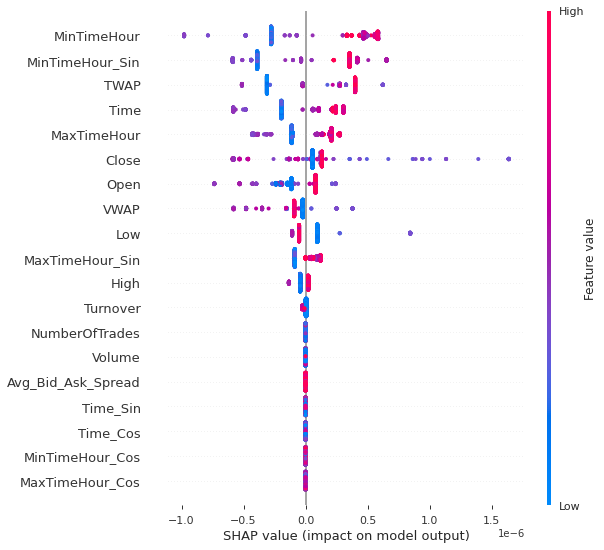

In [19]:
shap.summary_plot(shap_values, X)

In [20]:
X

,Time,Open,High,Low,Close,VWAP,TWAP,NumberOfTrades,Volume,Turnover,MinTimeHour,MaxTimeHour,Avg_Bid_Ask_Spread,Time_Sin,Time_Cos,MinTimeHour_Sin,MinTimeHour_Cos,MaxTimeHour_Sin,MaxTimeHour_Cos
0,1.515139e+09,53.863636,53.959091,53.509091,53.545455,53.753585,53.743282,2114,1.995475e+05,1.297645e+09,1.515139,1.515139,-0.064738,8.660254e-01,-0.500000,0.000110,1.0,0.000110,1.0
1,1.515143e+09,53.554545,53.727273,53.536364,53.709091,53.626634,53.623065,912,7.134927e+04,4.629420e+08,1.515143,1.515143,0.011634,7.071068e-01,-0.707107,0.000110,1.0,0.000110,1.0
2,1.515146e+09,53.709091,54.729601,53.345455,53.363636,54.510399,53.583943,965,3.674135e+05,2.382183e+09,1.515146,1.515146,0.011540,5.000000e-01,-0.866025,0.000110,1.0,0.000110,1.0
3,1.515150e+09,53.372727,53.545145,53.363636,53.472727,53.466642,53.467784,790,4.308400e+04,2.787363e+08,1.515150,1.515150,0.011123,2.588190e-01,-0.965926,0.000110,1.0,0.000110,1.0
4,1.515154e+09,53.509091,53.681818,53.500000,53.590909,53.583449,53.586309,504,2.879527e+04,1.867069e+08,1.515154,1.515154,-0.006231,1.942621e-11,-1.000000,0.000110,1.0,0.000110,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,1.528974e+09,34.986364,35.080445,34.636364,34.718182,34.816504,34.796264,2697,1.527895e+05,6.432968e+08,1.528974,1.528974,0.004185,2.588190e-01,-0.965926,0.000111,1.0,0.000111,1.0
1010,1.528978e+09,34.713636,34.770273,34.459091,34.509091,34.581861,34.582963,3527,1.829505e+05,7.655632e+08,1.528978,1.528978,0.007030,1.560005e-11,-1.000000,0.000111,1.0,0.000111,1.0
1011,1.528981e+09,34.500000,34.768182,34.390909,34.631818,34.539470,34.540540,5375,2.995654e+05,1.252005e+09,1.528981,1.528981,0.008004,-2.588190e-01,-0.965926,0.000111,1.0,0.000111,1.0
1012,1.528985e+09,34.631818,34.668182,34.330455,34.368182,34.445519,34.442075,5470,3.029528e+05,1.262553e+09,1.528985,1.528985,0.007508,-5.000000e-01,-0.866025,0.000111,1.0,0.000111,1.0
